# พยากรณ์ดัชนีราคาผู้บริโภคโดยแบบจำลอง Regression with SARIMA Errors

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.stattools import durbin_watson
import seaborn as sns

# 1. จัดเตรียมข้อมูล

In [16]:
data = pd.read_csv('/Users/1hundredeyes/factors_cpi_new.csv')

* ตรวจสอบค่า Null ในชุดข้อมูล

In [2123]:
data.isnull().sum()

cpi            0
policy_rate    0
xrt            0
m2             0
export         0
import         0
dtype: int64

* สร้าง Index ให้เป็น datetime เพื่อให้สะดวกต่อการวิเคราะห์ตัวแบบ Regression with SARIMA Errors

In [18]:
data["month"] = pd.to_datetime(data["month"]) 
data.set_index("month", inplace = True) 
data = data.asfreq('MS') 

In [20]:
data = data.drop(data.loc['2023':].index)

* take log ให้กับข้อมูล เนื่องจากตัวแปรอิสระบางตัวมีขนาดที่แตกต่างกันมาก

In [16]:
data = np.log(data)

In [644]:
pd.set_option('display.max_rows', None)

In [2292]:
data

,cpi,policy_rate,xrt,m2,export,import
month,,,,,,
2010-01-01,86.92,1.25,33.04,10601551.0,445612.73,441271.20
2010-02-01,87.40,1.25,33.15,10683909.0,464457.75,462600.19
2010-03-01,87.60,1.25,32.51,10855023.0,531743.34,515916.07
2010-04-01,88.04,1.25,32.29,10831395.0,448078.47,472245.39
2010-05-01,88.21,1.25,32.39,11001115.0,526100.09,464153.35
2010-06-01,88.44,1.25,32.47,10845954.0,576358.24,510526.45
2010-07-01,88.57,1.50,32.33,10886627.0,496556.82,536355.14
2010-08-01,88.79,1.75,31.74,10967388.0,522887.85,512519.81
2010-09-01,88.72,1.75,30.83,11115259.0,562039.20,475324.83


* แบ่งข้อมูลออกเป็น 2 ส่วน โดยส่วนแรกจะเป็นจะเป็นข้อมูลตั้งแต่วันที่ 1 มกราคม ค.ศ. 2553 ถึงวันที่ 31 ธันวาคม พ.ศ. 2561 มีสัดส่วนเป็นร้อยละ 70 ของข้อมูลทั้งหมด ซึ่งเป็นข้อมูลที่ใช้ในการสร้างตัวแบบ(Training Data) และส่วนที่สองจะเป็นข้อมูลตั้งแต่วันที่ 1 มกราคม ค.ศ. 2562 ถึงวันที่ 31 ธันวาคม พ.ศ. 2565 มีสัดส่วนเป็นร้อยละ 30 ของข้อมูลทั้งหมด ซึ่งเป็นข้อมูลที่ใช้ในการตรวจสอบประสิทธิภาพในการพยากรณ์(Testing Data)

In [22]:
split_date = "2018-12-01"
data_train = data[:split_date] 
data_test = data[split_date:].iloc[1:]

In [2125]:
data_train.shape

(108, 6)

In [2127]:
data_train

,cpi,policy_rate,xrt,m2,export,import
month,,,,,,
2010-01-01,4.464988,0.223144,3.497719,16.176511,13.007206,12.997415
2010-02-01,4.470495,0.223144,3.501043,16.184249,13.048626,13.044618
2010-03-01,4.472781,0.223144,3.481548,16.200138,13.183916,13.153699
2010-04-01,4.477791,0.223144,3.474758,16.197959,13.012724,13.065254
2010-05-01,4.479720,0.223144,3.477850,16.213507,13.173247,13.047970
2010-06-01,4.482324,0.223144,3.480317,16.199303,13.264485,13.143198
2010-07-01,4.483793,0.405465,3.475996,16.203046,13.115453,13.192552
2010-08-01,4.486274,0.559616,3.457578,16.210437,13.167122,13.147095
2010-09-01,4.485485,0.559616,3.428488,16.223829,13.239327,13.071754


# 2. วิเคราะห์ความสัมพันธ์เชิงเส้นระหว่างตัวแปรตาม และตัวแปรอิสระ

ตัวแปรตาม คือ ดัชนีราคาผู้บริโภค(cpi)

ตัวแปรอิสระ ได้แก่ 1. อัตราแลกเปลี่ยนเงินบาทต่อดอลลาร์สหรัฐ(xrt), 2. ปริมาณเงินความหมายกว้าง(m2), 3. ราคาส่งออก(export) และ 4. ราคานำเข้า(import)

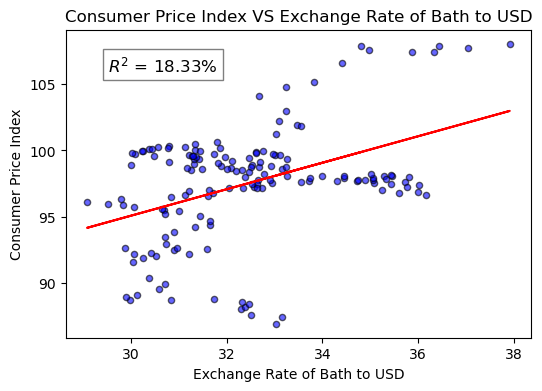

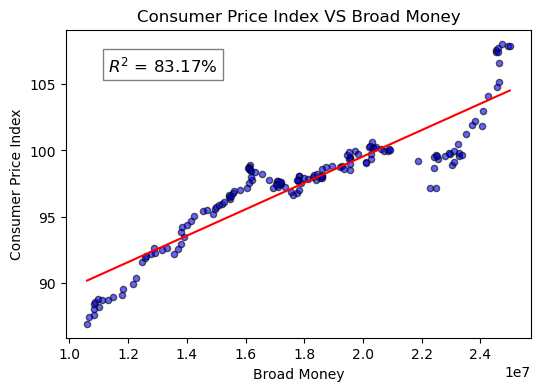

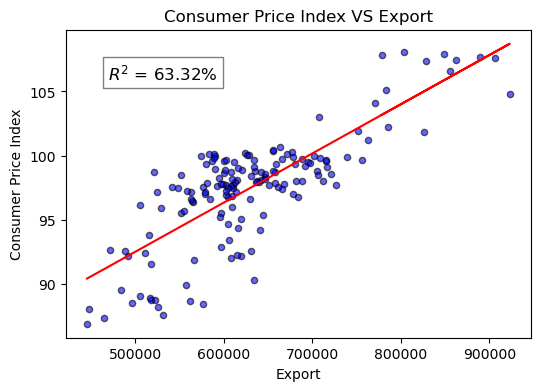

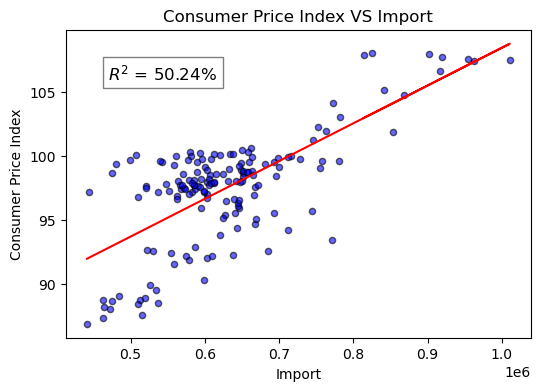

In [32]:
plt.figure(figsize=(6,4))
plt.scatter(data['xrt'],data['cpi'] , color='blue', s=20,  alpha=0.6, edgecolors='k')
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data['xrt'],data['cpi'])
plt.plot(data['xrt'], slope * data['xrt'] + intercept, color='red')
plt.text(min(data['xrt']) + (max(data['xrt']) - min(data['xrt'])) * 0.05, max(data['cpi']) - (max(data['cpi']) - min(data['cpi'])) * 0.1, 
         f"$R^2$ = {rvalue ** 2*100:.2f}%", fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Exchange Rate of Bath to USD')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index VS Exchange Rate of Bath to USD')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(data['m2'],data['cpi'] , color='blue', s=20,  alpha=0.6, edgecolors='k')
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data['m2'],data['cpi'])
plt.text(min(data['m2']) + (max(data['m2']) - min(data['m2'])) * 0.05, max(data['cpi']) - (max(data['cpi']) - min(data['cpi'])) * 0.1, 
         f"$R^2$ = {rvalue ** 2*100:.2f}%", fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.plot(data['m2'], slope * data['m2'] + intercept, color='red')
plt.xlabel('Broad Money')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index VS Broad Money')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(data['export'],data['cpi'] , color='blue', s=20,  alpha=0.6, edgecolors='k')
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data['export'],data['cpi'])
plt.plot(data['export'], slope * data['export'] + intercept, color='red')
plt.text(min(data['export']) + (max(data['export']) - min(data['export'])) * 0.05, max(data['cpi']) - (max(data['cpi']) - min(data['cpi'])) * 0.1, 
         f"$R^2$ = {rvalue ** 2*100:.2f}%", fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Export')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index VS Export')
plt.show()

plt.figure(figsize=(6,4))
plt.scatter(data['import'],data['cpi'] , color='blue', s=20,  alpha=0.6, edgecolors='k')
slope, intercept, rvalue, pvalue, stderr = stats.linregress(data['import'],data['cpi'])
plt.plot(data['import'], slope * data['import'] + intercept, color='red')
plt.text(min(data['import']) + (max(data['import']) - min(data['import'])) * 0.05, max(data['cpi']) - (max(data['cpi']) - min(data['cpi'])) * 0.1, 
         f"$R^2$ = {rvalue ** 2*100:.2f}%", fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.5))
plt.xlabel('Import')
plt.ylabel('Consumer Price Index')
plt.title('Consumer Price Index VS Import')
plt.show()

สามารถอธิบายถึงความสัมพันธ์ระหว่างปัจจัยที่มีผลต่อดัชนีราคาผู้บริโภค และดัชนีราคาผู้บริโภค ได้ดังนี้

1.) R-Squared = 18.33% หมายถึง อัตราแลกเปลี่ยนเงินบาทต่อดอลลาร์สหรัฐ และดัชนีราคาผู้บริโภคของประเทศไทย มีระดับความสัมพันธ์ที่ร้อยละ 18.33 และมีความสัมพันธ์ในทิศทางเดียวกัน หมายความว่า หากอัตราแลกเปลี่ยนเงินบาทต่อดอลลาร์สหรัฐมีค่าเพิ่มขึ้นจะส่งผลให้ดัชนีราคาผู้บริโภคของประเทศไทยมีค่าเพิ่มขึ้นตามไปด้วย

2.) R-Squared = 83.17% หมายถึง ปริมาณเงินความหมายกว้างของประเทศไทย และดัชนีราคาผู้บริโภคของประเทศไทย มีระดับความสัมพันธ์ที่ร้อยละ 83.17 และมีความสัมพันธ์ในทิศทางเดียวกัน หมายความว่า หากปริมาณเงินความหมายกว้างของประเทศไทยมีค่าเพิ่มขึ้นจะส่งผลให้ดัชนีราคาผู้บริโภคของประเทศไทยมีค่าเพิ่มขึ้นตามไปด้วย

3.) R-Squared = 63.32% หมายถึง มูลค่าส่งออกของประเทศไทย และดัชนีราคาผู้บริโภคของประเทศไทย มีระดับความสัมพันธ์ที่ร้อยละ 63.32 และมีความสัมพันธ์ในทิศทางเดียวกัน หมายความว่า หากมูลค่าส่งออกของประเทศไทยมีค่าเพิ่มขึ้นจะส่งผลให้ดัชนีราคาผู้บริโภคของประเทศไทยมีค่าเพิ่มขึ้นตามไปด้วย

4.) R-Squared = 50.24% หมายถึง มูลค่านำเข้าของประเทศไทย และดัชนีราคาผู้บริโภคของประเทศไทย มีระดับความสัมพันธ์ที่ร้อยละ 50.24 และมีความสัมพันธ์ในทิศทางเดียวกัน หมายความว่า หากมูลค่านำเข้าของประเทศไทยมีค่าเพิ่มขึ้นจะส่งผลให้ดัชนีราคาผู้บริโภคของประเทศไทยมีค่าเพิ่มขึ้นตามไปด้วย

# 3. คัดเลือกตัวแปรอิสระเข้าสมการด้วยวิธี Stepwise

In [20]:
x_train, x_test = data_train[['xrt', 'm2', 'export', 'import']], data_test[['xrt', 'm2', 'export', 'import']]
y_train, y_test = data_train['cpi'], data_test['cpi']

In [22]:
def stepwise_selection(x_train, y_train, threshold_in=0.05, threshold_out=0.1):
    initial_features = list(x_train.columns) 
    best_features = []

    while True:
        changed = False

        remaining_features = list(set(initial_features) - set(best_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        for new_column in remaining_features:
            model = sm.OLS(y_train, sm.add_constant(x_train[best_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]

        if not new_pval.empty and new_pval.min() < threshold_in:
            best_feature = new_pval.idxmin()
            best_features.append(best_feature)
            changed = True

        model = sm.OLS(y_train, sm.add_constant(x_train[best_features])).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()

        if worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            best_features.remove(worst_feature)
            changed = True

        if not changed:
            break

    return best_features

selected_features = stepwise_selection(x_train, y_train)
print("Selected Features:", selected_features)

Selected Features: ['m2', 'import']


ตัวแปรอิสระที่ผ่านการคัดเลือกด้วยวิธี Stepwise มี 2 ตัวแปร ได้แก่ 1.) ปริมาณเงินความหมายกว้าง(m2) และ 2.) ราคานำเข้า(import)

# 4. วิเคราะห์ตัวแปรอิสระที่ผ่านการคัดเลือกด้วยวิธี Stepwise มีความสัมพันธ์กันหรือไม่ ด้วยสถิติทดสอบ Variance Inflation Factor(VIF)

In [2131]:
x = sm.add_constant(data_train[['m2', 'import']])

vif_data = pd.DataFrame()
vif_data["Variable"] = x.columns
vif_data["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

vif_data

,Variable,VIF
0,const,15410.721147
1,m2,1.428142
2,import,1.428142


จากผลลัพธ์ข้างต้นค่า VIF ของ ปริมาณเงินความหมายกว้าง(m2) = 1.43 และ ราคานำเข้า(import) = 1.43 ซึ่ง < 10 หมายความว่าตัวแปนอิสระทั้งสองไม่มีความสัมพันธ์กัน ซึ่งเหมาะสำหรับใช้ในการเข้าสมการของตัวแบบ Multiple Linear Regression

# 5. ประมาณค่าพารามิเตอร์ในตัวแบบ Multiple Linear Regression ด้วยวิธีกำลังสองน้อยที่สุด

In [2298]:
model_regress = sm.OLS(data_train['cpi'], sm.add_constant(data_train[['m2', 'import']])).fit()
print(model_regress.summary())

                            OLS Regression Results                            
Dep. Variable:                    cpi   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     761.2
Date:                Sun, 16 Feb 2025   Prob (F-statistic):           3.22e-63
Time:                        13:54:26   Log-Likelihood:                 350.03
No. Observations:                 108   AIC:                            -694.1
Df Residuals:                     105   BIC:                            -686.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8669      0.115      7.559      0.0

จากผลการทดสอบพารามิเตอร์ในตัวแบบ Multiple Linear Regression พบว่ามีพารามิเตอร์ผ่านการคัดเลือกเข้าสมการครบทุกค่าพารามิเตอร์ ได้แก่ ค่าคงที่(const)
, ประมาณเงินความหมายกว้าง(m2) และ ราคานำเข้า(import) 

# 6. ตรวจสอบความเหมาะสมของตัวแบบ Multiple Linear Regression โดยการวิเคราะห์ส่วนเหลือ(Residual Analysis)

In [2300]:
resid_regress = model_regress.resid

6.1 ตรวจสอบสหสัมพันธ์ในตัวเอง (ACF) ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression

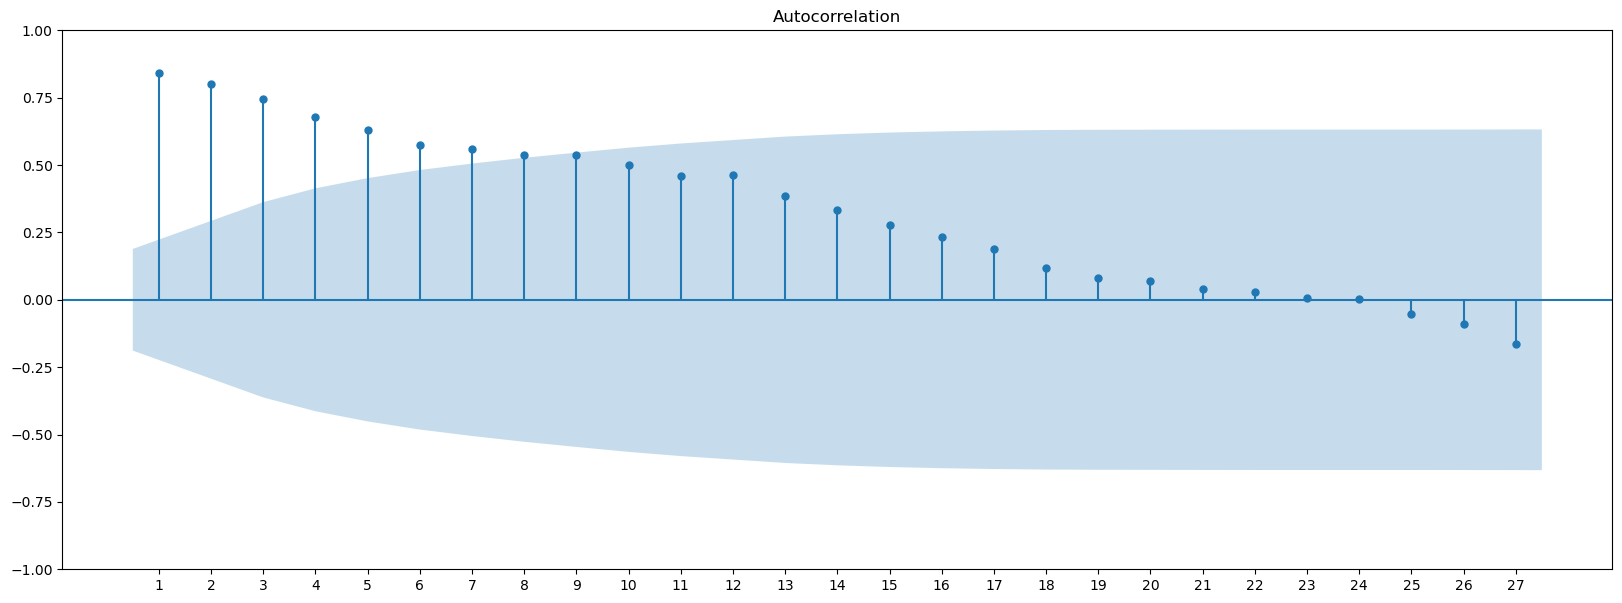

In [1936]:
numlags = 27
fig, ax = plt.subplots(figsize=(20,7))
acf_residual = plot_acf(resid_regress, lags = numlags, zero = False, ax=ax)
ax.set_xticks(np.arange(1, numlags +1, 1))
plt.show()

In [1938]:
dw_stat = durbin_watson(resid_regress)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 0.2987007516019791


จากการทดสอบพบว่า ค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (ACF) และวิธีทดสอบของ Durbin-Watson ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression มีสหสัมพันธ์ในตัวเอง

ซึ่งเราจะแก้ไขปัญหาความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression มีสหสัมพันธ์ในตัวเองได้โดยการสร้างตัวแบบ SARIMA ผ่านความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression


6.2 ตรวจสอบการแจกแจงปกติของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression โดยใช้วิธีการทดสอบของ Kolmogorov-Smirnov

In [1940]:
ks_statistic, p_value = stats.kstest(resid_regress, 'norm', args=(np.mean(resid_regress), np.std(resid_regress)))
print(f"KS Test Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

KS Test Statistic: 0.0791, P-value: 0.4837


จากการทดสอบของ Kolmogorov-Smirnov พบว่า p-value = 0.4837 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression มีการแจกแจงปกติ

6.3 ตรวจสอบค่าเฉลี่ยไม่แตกต่างจากศูนย์ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression โดยใช้ t-Test

In [1942]:
t_stat, p_value = stats.ttest_1samp(resid_regress, 0)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_value:.4f}")

T-statistic: -0.0000, P-value: 1.0000


จากการทดสอบโดยใช้ t-Test พบว่า p-value = 1.0000 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression มีเฉลี่ยไม่แตกต่างจากศูนย์

6.4 ตรวจสอบความแปรปรวนคงที่ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression โดยใช้วิธีการทดสอบของ Levene

In [1944]:
mid_point = len(resid_regress) // 3
residual1 = resid_regress.iloc[:mid_point] 
residual2 = resid_regress.iloc[mid_point: 2*mid_point]
residual3 = resid_regress.iloc[2*mid_point:]
statistic, p_value = stats.levene(residual1, residual2, residual3)
print(f"Levene's Test Statistic: {statistic:.4f}, P-value: {p_value:.4f}")

Levene's Test Statistic: 2.8653, P-value: 0.0614


จากการทดสอบของ Levene พบว่า p-value = 0.0614 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Multiple Linear Regression มีความแปรปรวนคงที่

# 7. วิเคราะห์ประสิทธิภาพในการพยากรณ์จากตัวแบบ Multiple Linear Regression เบื้องต้น

* วิเคราะห์ประสิทธิภาพในการพยากรณ์จากค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ผ่านชุดข้อมูล Testing Data

In [1946]:
pred_regress_test1 = model_regress.predict(sm.add_constant(data_test[['m2', 'import']]))

In [1948]:
resid_regress_test1 = data_test['cpi'] - pred_regress_test1

In [1950]:
MAD = np.mean(np.abs(resid_regress_test1))
MSE = np.mean(resid_regress_test1 ** 2)
MAPE = np.mean(np.abs(resid_regress_test1 / data_test['cpi'])) * 100
r2 = r2_score(data_test['cpi'], pred_regress_test1)*100

print(f"MAD: {MAD:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"MAPE: {MAPE:.4f}%")
print(f"R^2: {r2:.2f}%")

MAD: 0.0187
MSE: 0.0005
MAPE: 0.4050%
R^2: 43.26%


จากการวิเคราะห์เบื้องต้นพบว่า ค่า MAD, MSE และ MAPE มีค่าเข้าใกล้ศูนย์ ซึ่งหมายความว่าตัวแบบ Multiple Linear Regression มีประสิทธิภาพในการพยากรณ์คลาดเคลื่อนค่อนข้างต่ำ
แต่ถ้าหากพิจารณาจากค่า R-Squared มีค่าเท่า 43.26% ซึ่งมีค่าน้อยกว่า 50% หมายความว่าตัวแบบ Multiple Linear Regression อธิบายความแปรปรวนของข้อมูลได้ไม่ดีมากนัก ซึ่งอาจต้องแก้ปัญหาโดยการวิเคราะห์ตัวแบบ SARIMAX จากค่าความคลาดเคลื่อนที่ได้จากตัวแบบ Multiple Linear Regression มาพิจารณาร่วมกับตัวแบบ Multiple Linear Regression

# 8. ทดสอบคุณสมบัตินิ่งของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ด้วยวิธีของ Augmented Dicky-Fuller Test(ADF Test)

* เขียนกราฟเพื่อวิเคราะห์คุณสมบัตินิ่งของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression เบื้องต้น

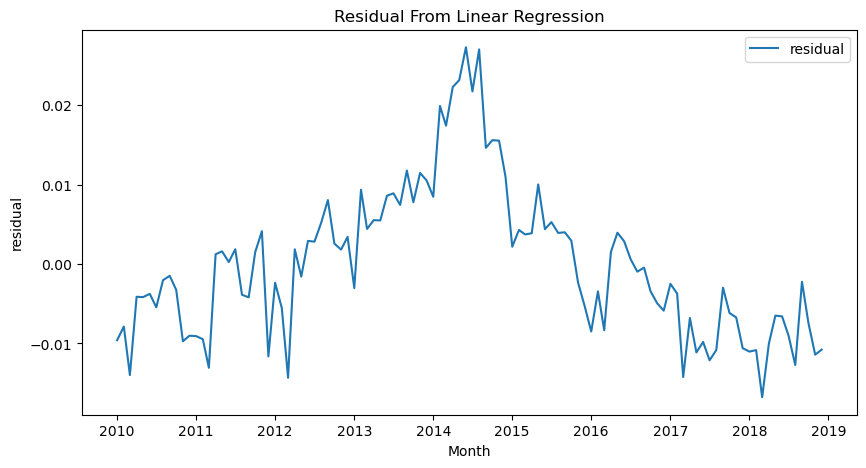

In [2187]:
plt.figure(figsize = (10,5))
plt.plot(resid_regress, label = ['residual'])
plt.title('Residual From Linear Regression')
plt.xlabel('Month')
plt.ylabel('residual')
plt.legend()
plt.show()

 จากกราฟพบว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ในบางช่วงเวลายังมีแนวโน้ม ซึ่งอาจต้องทำการหาผลต่างอันดับของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression

* ทดสอบ Augmented Dicky-Fuller Test(ADF Test) ของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression

In [1954]:
result = adfuller(resid_regress)
print(f'ADF Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

ADF Statistic: -1.8583
p-value: 0.3519


จากการทดสอบคุณสมบัตินิ่งของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ด้วยวิธี ADF Test พบว่า p-value มีค่าเท่ากับ 0.3519 ซึ่งมีค่ามากกว่าที่ระดับนัยสำคัญ 0.05 แสดงว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ไม่มีคุณสมบัตินิ่ง

* ทำการหาผลต่างอันดับที่ 1 และอันดับที่ 12 เนื่องจากข้อมูลมีฤดูกาล

In [1956]:
resid_regress_diff1_diff12 = resid_regress.diff(1).diff(12)
resid_regress_diff1_diff12.dropna(inplace = True)

* ทดสอบ Augmented Dicky-Fuller Test(ADF Test) ของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ที่มีการหาผลต่างอันดับที่ 1 และอันดับที่ 12

In [1958]:
result = adfuller(resid_regress_diff1_diff12)
print('ADF Statistic (After Differencing): %f' % result[0])
print('p-value (After Differencing): %f' % result[1])

ADF Statistic (After Differencing): -3.731023
p-value (After Differencing): 0.003697


จากการทดสอบคุณสมบัตินิ่งของค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression ที่มีการหาผลต่างอันดับที่ 1 และอันดับที่ 12 ด้วยวิธี ADF Test พบว่า p-value มีค่าเท่ากับ 0.0037 ซึ่งมีค่าน้อยกว่าที่ระดับนัยสำคัญ 0.05 แสดงว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression มีคุณสมบัตินิ่ง

จากกราฟพบว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression เคลื่อนที่รอบแกนศูนย์ แสดงว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression มีคุณสมบัตินิ่ง

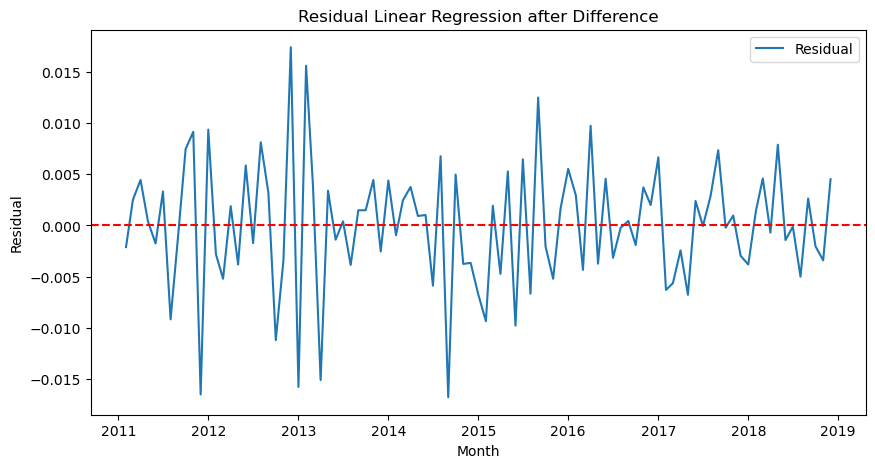

In [2185]:
plt.figure(figsize=(10,5))
plt.plot(resid_regress_diff1_diff12, label = "Residual")
plt.title("Residual Linear Regression after Difference")
plt.axhline(y=0, color="red", linestyle="--")
plt.xlabel("Month")
plt.ylabel("Residual") 
plt.legend()
plt.show()

# 9. เขียนกราฟค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (autocorrelation aunction, ACF) และค่าฟังก์ชันสหสัมพันธ์ในตัวเองส่วนย่อย (partial autocorrelation aunction, PACF) จากค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression

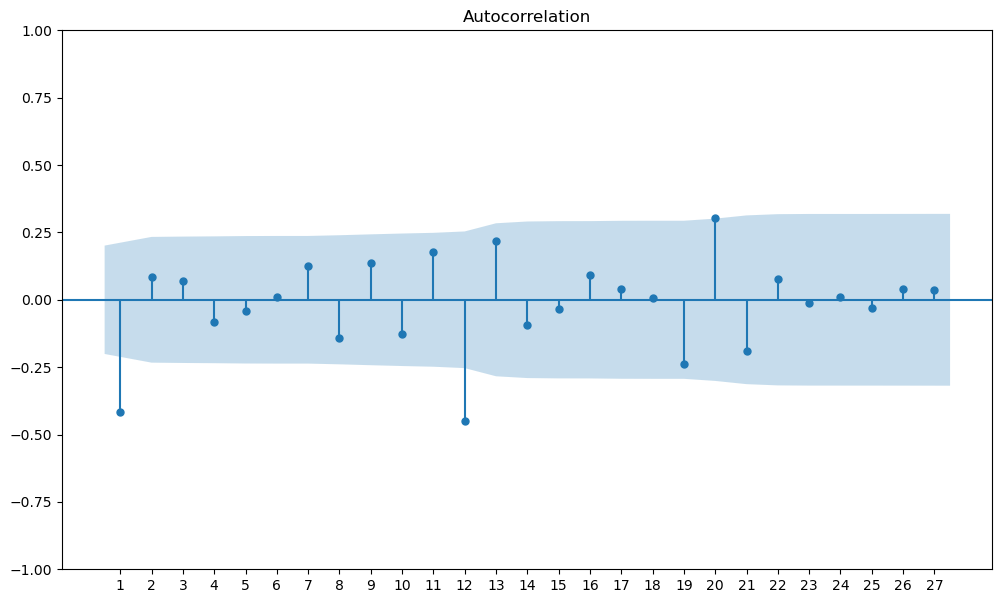

In [2183]:
fig, ax = plt.subplots(figsize=(12,7))
acf_diff1 = plot_acf(resid_regress_diff1_diff12, lags = 27, zero = False, ax = ax)
ax.set_xticks(np.arange(1, 27 + 1, 1))
plt.show()

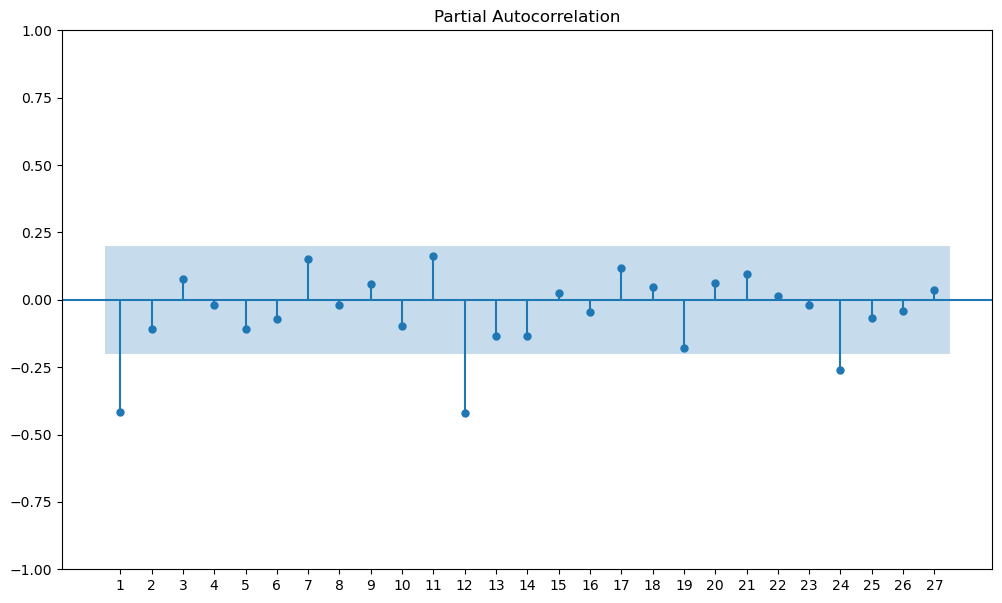

In [2181]:
fig, ax = plt.subplots(figsize=(12,7))
pacf_diff1 = plot_pacf(resid_regress_diff1_diff12, lags = 27, zero = False, ax = ax)
ax.set_xticks(np.arange(1, 27 + 1, 1))
plt.show()

จากกราฟ ACF และ PACF พบว่าค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Multiple Linear Regression มีสหสัมพันธ์ในตัวเอง ณ Lag ที่ 1, 12, 20 และมีสหสัมพันธ์ในตัวเองส่วนย่อย ณ Lag ที่ 1, 12, 24 

# 10. ประมาณค่าพารามิเตอร์ของตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยใช้วิธีกำลังสองน้อยที่สุด

In [2302]:
model_arima = SARIMAX(resid_regress, order=(1,1,[20]), seasonal_order=(2,1,0,12), enforce_stationarity=True, enforce_invertibility=True).fit()
print(model_arima.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.39003D+00    |proj g|=  9.56429D+01

At iterate    5    f= -3.42303D+00    |proj g|=  1.95568D-01

At iterate   10    f= -3.43934D+00    |proj g|=  2.79157D+01

At iterate   15    f= -3.45421D+00    |proj g|=  1.65592D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     48      1     0     0   1.656D-01  -3.454D+00
  F =  -3.4542136116873343     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


จากผลลัพธ์ข้างต้นพบว่า ค่าพารามิเตอร์ทุกตัวในตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 มี p-value น้อยกว่าที่ระดับนัยสำคัญ 0.05 สรุปได้ว่า พารามิเตอร์ทุกตัวในตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 มีค่าแตกต่างจากศูนย์ กล่าวคือ มีพารามิเตอร์แต่ละตัวอยู่ในตัวแบบ

# 11. ตรวจสอบความเหมาะสมของตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยการวิเคราะห์ส่วนเหลือ(Residual Analysis)

* คำนวณค่าความคลาดเคลื่อนจากการพยากรณ์ด้วยตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยลบข้อมูล 13 อันดับแรกจากการหาอันดับผลต่างของค่าความคลาดเคลื่อนที่ได้จากตัวแบบ Multiple Linear Regression 

In [1968]:
arima_resid = model_arima.resid[13:]

11.1 ตรวจสอบสหสัมพันธ์ในตัวเอง (ACF) ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12

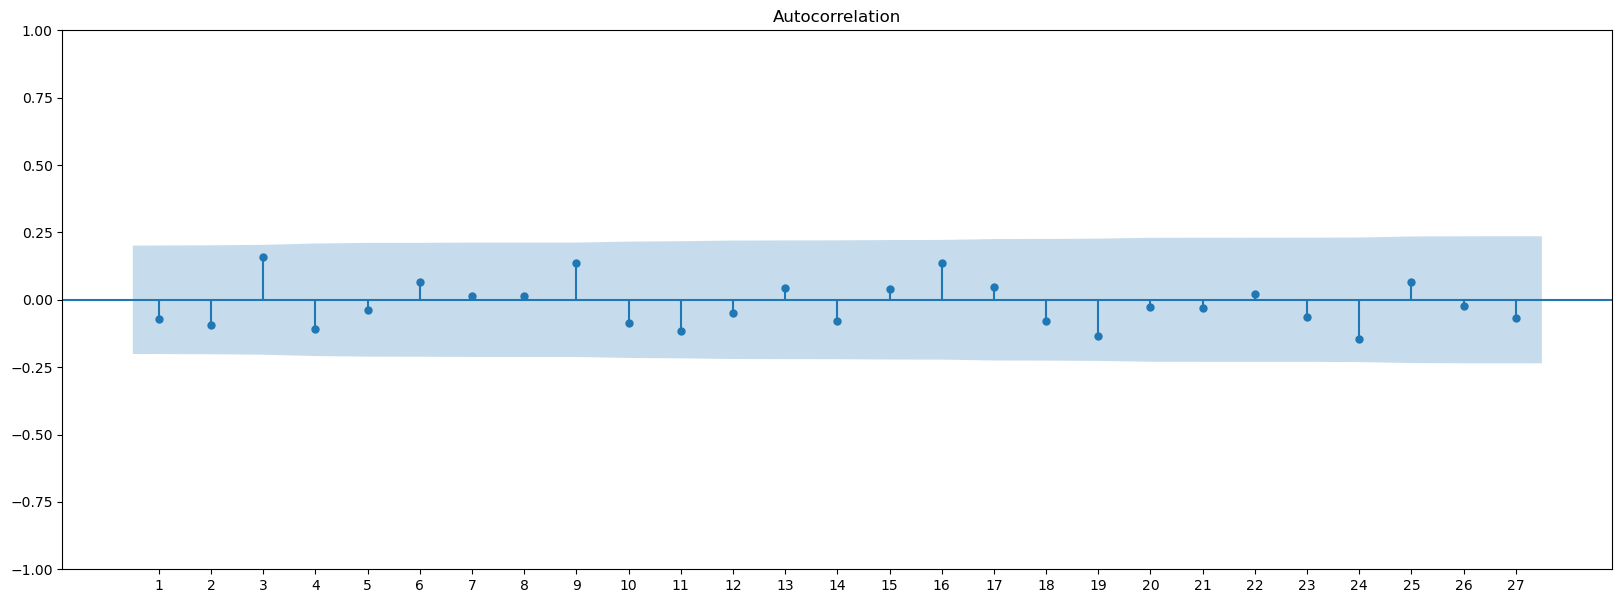

In [2179]:
fig, ax = plt.subplots(figsize=(12,7))
acf_diff1 = plot_acf(arima_resid, lags = 27, zero = False, ax = ax)
ax.set_xticks(np.arange(1, 27 + 1, 1))
plt.show()

In [2025]:
dw_stat = durbin_watson(arima_resid)
print(f'Durbin-Watson statistic: {dw_stat:.4f}')

Durbin-Watson statistic: 2.1401


จากการทดสอบพบว่า ค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (ACF) และวิธีทดสอบของ Durbin-Watson ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 ไม่มีสหสัมพันธ์ในตัวเอง

11.2 ตรวจสอบการแจกแจงปกติของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยใช้วิธีการทดสอบของ Kolmogorov-Smirnov

In [1974]:
ks_statistic, p_value = stats.kstest(arima_resid, 'norm', args=(np.mean(arima_resid), np.std(arima_resid)))
print(f"KS Test Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

KS Test Statistic: 0.0580, P-value: 0.8882


จากการทดสอบของ Kolmogorov-Smirnov พบว่า p-value = 0.8882 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 มีการแจกแจงปกติ

11.3 ตรวจสอบค่าเฉลี่ยไม่แตกต่างจากศูนย์ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยใช้ t-Test

In [1976]:
t_stat, p_value = stats.ttest_1samp(arima_resid, 0)
print(f"T-statistic: {t_stat}, P-value: {p_value:.4f}")

T-statistic: -0.0258343452247986, P-value: 0.9794


จากการทดสอบโดยใช้ t-Test พบว่า p-value = 0.9794 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 มีค่าเฉลี่ยไม่แตกต่างจากศูนย์

11.4 ตรวจสอบความแปรปรวนคงที่ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 โดยใช้วิธีการทดสอบของ Levene

In [1978]:
mid_point = len(arima_resid) // 3
arima_resid1 = arima_resid.iloc[:mid_point] 
arima_resid2 = arima_resid.iloc[mid_point: 2*mid_point]
arima_resid3 = arima_resid.iloc[2*mid_point:]
statistic, p_value = stats.levene(arima_resid1, arima_resid2, arima_resid3)
print(f"Levene's Test Statistic: {statistic}, P-value: {p_value:.4f}")

Levene's Test Statistic: 3.0233377127679653, P-value: 0.0535


จากการทดสอบของ Levene พบว่า p-value = 0.0535 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 มีความแปรปรวนคงที่

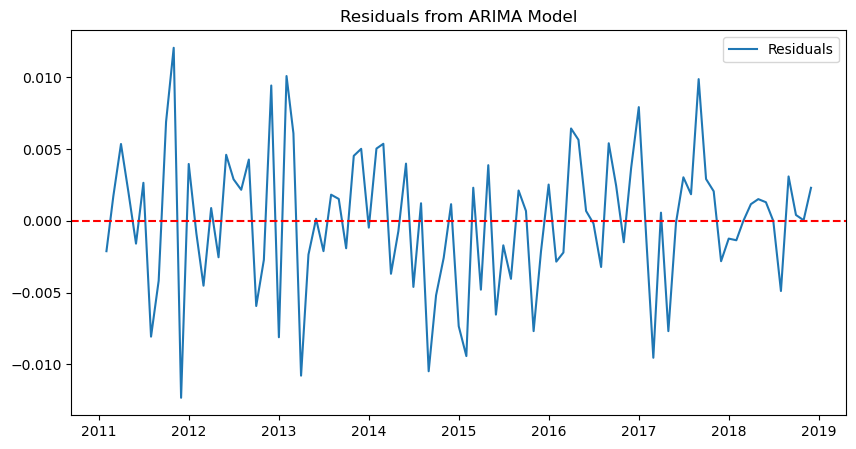

In [2194]:
plt.figure(figsize=(10,5))
plt.plot(arima_resid, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals from ARIMA Model")
plt.legend()
plt.show()

# 12. สร้างตัวแบบ Regression with SARIMA Errors

* รวมตัวแบบ Multiple Linear Regression และตัวแบบ SARIMA(1,1,(20))(2,1,0)s=12 เข้าด้วยกัน 

In [1980]:
pred_regress_train = model_regress.predict(sm.add_constant(data_train[['m2', 'import']]))

In [1982]:
data_train['pred_regress_train'] =  pred_regress_train

/var/folders/j4/9cv4ksxd5p11m01b59qb0wyw0000gn/T/ipykernel_1325/4240594271.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['pred_regress_train'] =  pred_regress_train


In [1984]:
resid_regress_train = data_train['cpi'] - data_train['pred_regress_train']

In [1986]:
data_train['resid_regress_train'] = resid_regress_train

/var/folders/j4/9cv4ksxd5p11m01b59qb0wyw0000gn/T/ipykernel_1325/141523862.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['resid_regress_train'] = resid_regress_train


* ตัวแบบ Regression with SARIMA Errors

In [1988]:
pred_regress_arima_train = (model_regress.predict(sm.add_constant(data_train[['m2', 'import']])) + model_arima.predict(start = 0, end = (len(data_train['resid_regress_train'])-1))) 

In [1990]:
data_train['pred_regress_arima_train'] = pred_regress_arima_train

/var/folders/j4/9cv4ksxd5p11m01b59qb0wyw0000gn/T/ipykernel_1325/1525213175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['pred_regress_arima_train'] = pred_regress_arima_train


# 13. ตรวจสอบความเหมาะสมของตัวแบบ Regression with SARIMA Errors โดยการวิเคราะห์ส่วนเหลือ(Residual Analysis)


In [1994]:
resid_regress_arima_train = data_train['cpi'] - data_train['pred_regress_arima_train']

In [1996]:
resid_regress_arima_train = resid_regress_arima_train[13:]

In [2002]:
print(resid_regress_arima_train)

month
2011-02-01   -0.002109
2011-03-01    0.001729
2011-04-01    0.005360
2011-05-01    0.002027
2011-06-01   -0.001581
2011-07-01    0.002656
2011-08-01   -0.008062
2011-09-01   -0.004165
2011-10-01    0.006905
2011-11-01    0.012063
2011-12-01   -0.012323
2012-01-01    0.003969
2012-02-01   -0.000866
2012-03-01   -0.004513
2012-04-01    0.000897
2012-05-01   -0.002533
2012-06-01    0.004609
2012-07-01    0.002902
2012-08-01    0.002169
2012-09-01    0.004274
2012-10-01   -0.005929
2012-11-01   -0.002712
2012-12-01    0.009435
2013-01-01   -0.008105
2013-02-01    0.010095
2013-03-01    0.006099
2013-04-01   -0.010781
2013-05-01   -0.002349
2013-06-01    0.000150
2013-07-01   -0.002107
2013-08-01    0.001828
2013-09-01    0.001531
2013-10-01   -0.001906
2013-11-01    0.004534
2013-12-01    0.005024
2014-01-01   -0.000467
2014-02-01    0.005040
2014-03-01    0.005375
2014-04-01   -0.003683
2014-05-01   -0.000716
2014-06-01    0.003992
2014-07-01   -0.004599
2014-08-01    0.001230
2014-

13.1 ตรวจสอบสหสัมพันธ์ในตัวเอง (ACF) ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors

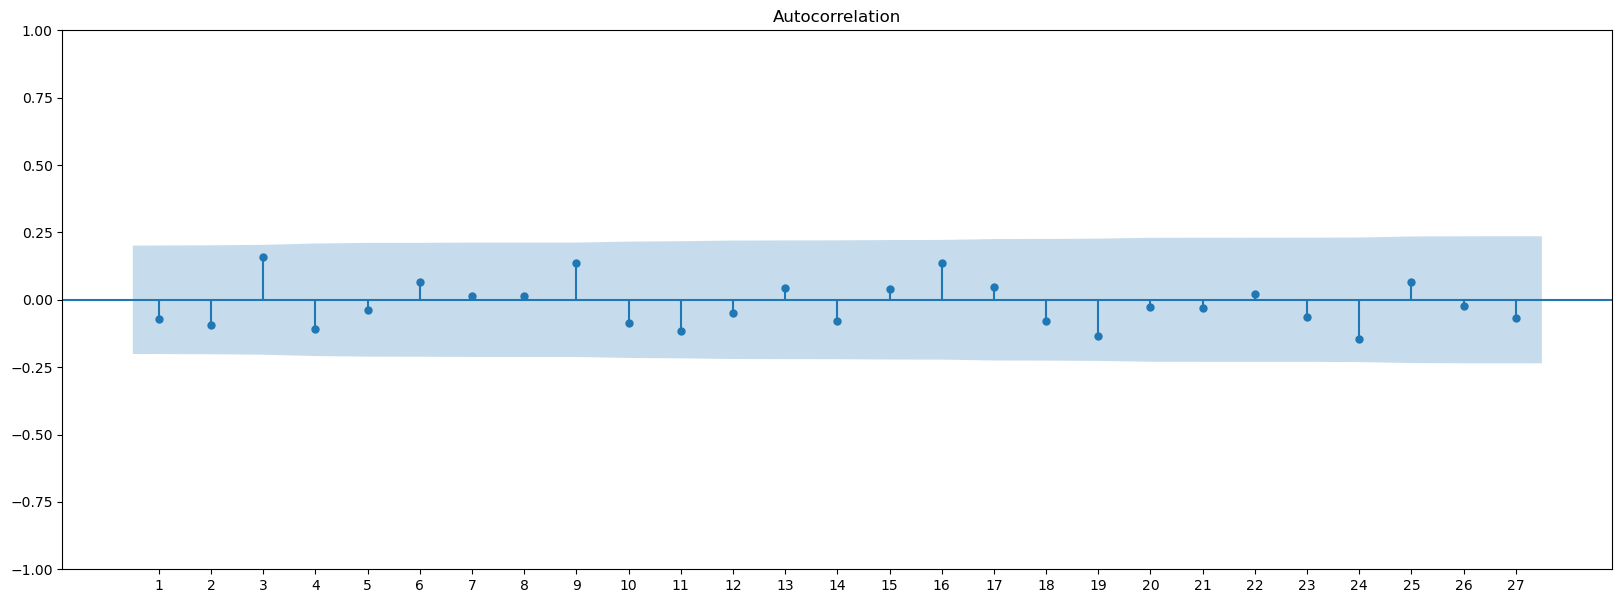

In [2177]:
fig, ax = plt.subplots(figsize=(20,7))
acf_diff1 = plot_acf(resid_regress_arima_train, lags = 27, zero = False, ax = ax)
ax.set_xticks(np.arange(1, 27 + 1, 1))
plt.show()

In [2016]:
dw_stat = durbin_watson(resid_regress_arima_train)
print(f'Durbin-Watson statistic: {dw_stat:.4f}')

Durbin-Watson statistic: 2.1401


จากการทดสอบพบว่า ค่าฟังก์ชันสหสัมพันธ์ในตัวเอง (ACF) และวิธีทดสอบของ Durbin-Watson ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors ไม่มีสหสัมพันธ์ในตัวเอง

13.2 ตรวจสอบการแจกแจงปกติของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors โดยใช้วิธีการทดสอบของ Kolmogorov-Smirnov

In [2006]:
ks_statistic, p_value = stats.kstest(resid_regress_arima_train, 'norm', args=(np.mean(resid_regress_arima_train), np.std(resid_regress_arima_train)))
print(f"KS Test Statistic: {ks_statistic:.4f}, P-value: {p_value:.4f}")

KS Test Statistic: 0.0580, P-value: 0.8882


จากการทดสอบของ Kolmogorov-Smirnov พบว่า p-value = 0.8882 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors มีการแจกแจงปกติ

13.3 ตรวจสอบค่าเฉลี่ยไม่แตกต่างจากศูนย์ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors โดยใช้ t-Test

In [2018]:
t_stat, p_value = stats.ttest_1samp(resid_regress_arima_train, 0)
print(f"T-statistic: {t_stat}, P-value: {p_value:.4f}")

T-statistic: -0.025834345224719377, P-value: 0.9794


จากการทดสอบโดยใช้ t-Test พบว่า p-value = 0.9794 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors มีค่าเฉลี่ยไม่แตกต่างจากศูนย์

13.4 ตรวจสอบความแปรปรวนคงที่ของความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors โดยใช้วิธีการทดสอบของ Levene

In [2020]:
mid_point = len(resid_regress_arima_train) // 3
residual1 = resid_regress_arima_train.iloc[:mid_point] 
residual2 = resid_regress_arima_train.iloc[mid_point: 2*mid_point]
residual3 = resid_regress_arima_train.iloc[2*mid_point:]
statistic, p_value = stats.levene(residual1, residual2, residual3)
print(f"Levene's Test Statistic: {statistic:.4f}, P-value: {p_value:.4f}")

Levene's Test Statistic: 3.0233, P-value: 0.0535


จากการทดสอบของ Levene พบว่า p-value = 0.0535 ซึ่งมีค่ามากกว่าที่ระดับนับสำคัญ 0.05 สรุปได้ว่า ความคลาดเคลื่อนสุ่มที่ได้จากตัวแบบ Regression with SARIMA Errors มีความแปรปรวนคงที่

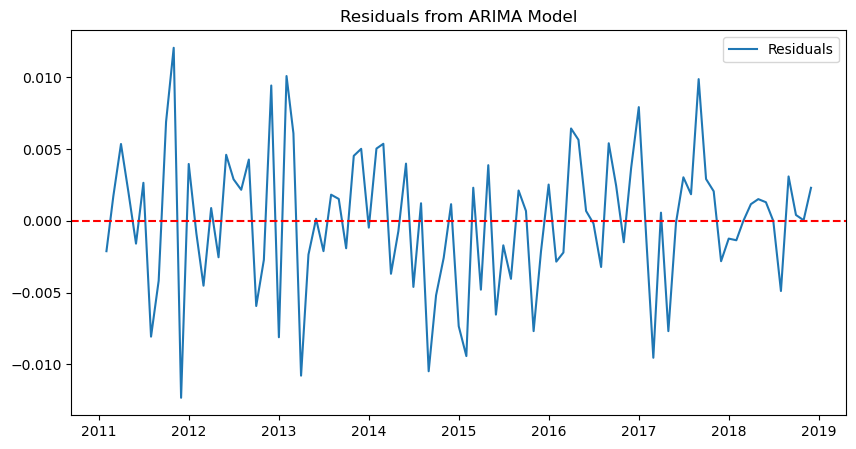

In [2175]:
plt.figure(figsize=(10,5))
plt.plot(resid_regress_arima_train, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals from ARIMA Model")
plt.legend()
plt.show()

# 14. วิเคราะห์ประสิทธิภาพในการพยากรณ์จากตัวแบบ Regression with SARIMA Errors 

* วิเคราะห์ประสิทธิภาพในการพยากรณ์จากค่าความคลาดเคลื่อนที่ได้จากการพยากรณ์ด้วยตัวแบบ Regression with SARIMA Errors ผ่านชุดข้อมูล Testing Data

In [2042]:
pred_regress_test = model_regress.predict(sm.add_constant(data_test[['m2', 'import']]))

In [2044]:
data_test['pred_regress_test'] = pred_regress_test

In [2046]:
resid_regress_test = data_test['cpi'] - data_test['pred_regress_test']

In [2048]:
data_test['resid_regress_test'] = resid_regress_test

In [2050]:
pred_regress_arima_test = (model_regress.predict(sm.add_constant(data_test[['m2', 'import']])) + model_arima.forecast(steps =len(data_test['resid_regress_test'])))

In [2052]:
data_test['pred_regress_arima_test'] = pred_regress_arima_test

In [2054]:
data_test = data_test[13:]

In [2056]:
resid_regress_arima_test = data_test['cpi'] - data_test['pred_regress_arima_test']

In [2058]:
data_test['resid_regress_arima_test'] = resid_regress_arima_test

In [2064]:
MAD = np.mean(np.abs(data_test['resid_regress_arima_test']))
MSE = np.mean(data_test['resid_regress_arima_test'] ** 2)
MAPE = np.mean(np.abs(data_test['resid_regress_arima_test'] / data_test['cpi'])) * 100
r2 = r2_score(data_test['cpi'], data_test['pred_regress_arima_test'])*100

print(f"MAD: {MAD:.4f}")
print(f"MSE: {MSE:.4f}")
print(f"MAPE: {MAPE:.4f}%")
print(f"R-Squared: {r2:.2f}%")

MAD: 0.0184
MSE: 0.0004
MAPE: 0.3981%
R-Squared: 63.82%


จากการวิเคราะห์เบื้องต้นพบว่า ค่า MAD, MSE และ MAPE มีค่าเข้าใกล้ศูนย์ ซึ่งหมายความว่าตัวแบบ Regression with SARIMA Errors มีประสิทธิภาพในการพยากรณ์คลาดเคลื่อนค่อนข้างต่ำ และเมื่อพิจารณาจากค่า R-Squared มีค่าเท่ากับ 63.82% ซึ่งมีค่ามมากกว่า 50% หมายความว่าตัวแบบ Regression with SARIMA Errors มีประสิทธิภาพในการพยากรณ์ค่อนข้างดี แต่อาจมีข้อมูลบางช่วงเวลาที่มีความแปรปรวนสูง ซึ่งตัวแบบ Regression with SARIMA Errors อาจมีประสิทธิภาพในการอธิบายความแปรปรวน ณ ช่วงเวลานั้นได้ไม่ดีมากนัก

# 15. เขียนกราฟเปรียบเทียบค่าที่แท้จริง กับค่าพยากรณ์ด้วยตัวแบบ Regression with SARIMA Errors

In [2304]:
pred_regress_data = model_regress.predict(sm.add_constant(data[['m2', 'import']]))

In [2306]:
resid_regress_data = data['cpi'] - pred_regress_data

In [2308]:
pred_regress_arima_data = (model_regress.predict(sm.add_constant(data[['m2', 'import']])) + model_arima.predict(start = 0, end = len(resid_regress_data) - 1))

In [2165]:
#pred_regress_arima_data = (model_regress.predict(sm.add_constant(data[['m2', 'import']])) + model_arima.forecast(steps=len(resid_regress_data)))

In [2318]:
pred_regress_arima_data

month
2011-02-01     90.109855
2011-03-01     90.203895
2011-04-01     91.110367
2011-05-01     91.723912
2011-06-01     92.175631
2011-07-01     91.955433
2011-08-01     93.349576
2011-09-01     92.665146
2011-10-01     91.823778
2011-11-01     91.548912
2011-12-01     93.363413
2012-01-01     92.213315
2012-02-01     93.000545
2012-03-01     93.892782
2012-04-01     93.775848
2012-05-01     94.468962
2012-06-01     93.956002
2012-07-01     94.435590
2012-08-01     94.883984
2012-09-01     94.993116
2012-10-01     96.098032
2012-11-01     95.448508
2012-12-01     94.662615
2013-01-01     96.488890
2013-02-01     94.956597
2013-03-01     95.396361
2013-04-01     97.171946
2013-05-01     96.596630
2013-06-01     96.495554
2013-07-01     96.813802
2013-08-01     96.423545
2013-09-01     96.612002
2013-10-01     97.104859
2013-11-01     96.581064
2013-12-01     96.673133
2014-01-01     97.605566
2014-02-01     97.308320
2014-03-01     97.474679
2014-04-01     98.853363
2014-05-01     98.9

In [2312]:
pred_regress_arima_data = pred_regress_arima_data[13:]

In [2314]:
data = np.exp(data)

In [2316]:
pred_regress_arima_data = np.exp(pred_regress_arima_data)

* กราฟเปรียบค่าที่แท้จริง กับค่าพยากรณ์ของข้อมูลดัชนีราคาผู้บริโภคของประเทศไทย รายเดือนตั้งแต่เดือนมกราคม พ.ศ. 2553 ถึงเดือนธันวาคม พ.ศ. 2566 ด้วยตัวแบบ Regression with SARIMA Errors

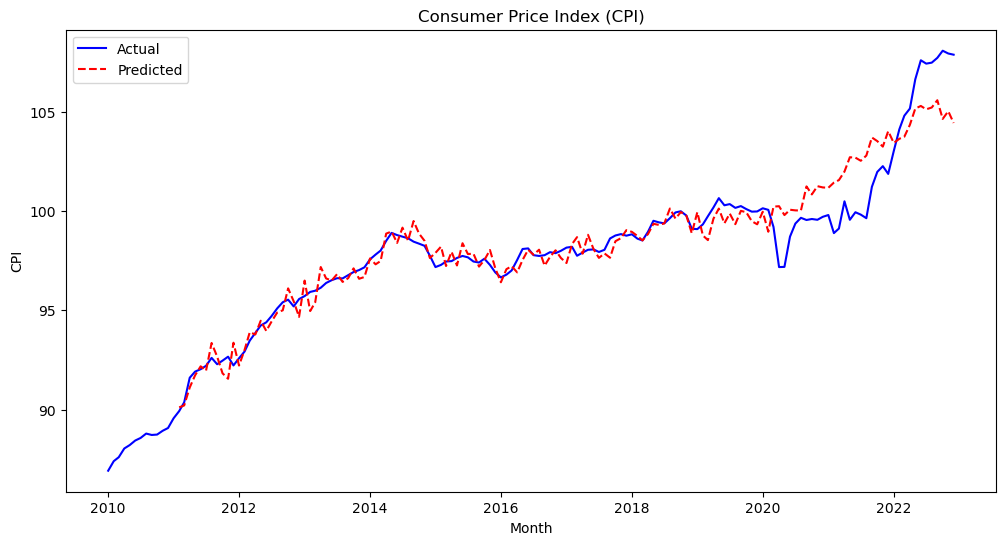

In [2320]:
plt.figure(figsize=(12,6))
plt.plot(data['cpi'], label="Actual", color="blue")
plt.plot(pred_regress_arima_data, label="Predicted", color="red", linestyle="--")
plt.title('Consumer Price Index (CPI)')
plt.xlabel("Month")
plt.ylabel("CPI")
plt.legend()
plt.show()

จากกราฟพบว่า ช่วงปี พ.ศ.2563 ถึงปี พ.ศ.2565 ดัชนีราคาผู้บริโภคของประเทศไทยมีความแปรปรวนสูง ซึ่งอาจได้รับอิทธิพลของความไม่แน่นอน เช่น การระบาดของเชื้อ COVID-19 ซึ่งเริ่มระบาดหนักในประเทศไทยในช่วงต้นปี พ.ศ.2563 โดยเหตุการณ์ดังกล่าวส่งผลทำให้ตัวแบบ Regression with SARIMA Errors มีประสิทธิภาพในการพยากรณ์ดัชนีราคาผู้บริโภคของประเทศไทยได้ไม่แม่นยำมากนัก แต่ยังคงมีประสิทธิภาพในพยากรณ์แนวโน้มของดัชนีราคาผู้บริโภคได้แม่นยำมากกว่าตัวแบบ SARIMA เนื่องจากตัวแบบ Regression with SARIMA Errors ได้มีการนำปัจจัยที่สงผลต่อดัชนีราคาผู้บริโภคมาร่วมพิจารณากับตัวแบบ 